In [1]:
# Based on the Kaggle notebook by Elias Tchourdakis: 
# "Connect 4 Negamax Agent with Memoization", 
# available at https://www.kaggle.com/code/etchourdakis/connect-4-negamax-agent-with-memoization
# Modified and expanded by Claude (Anthropic) in collaboration with Group 4's members

# Kaggle specific imports
from kaggle_environments import evaluate, make, utils

# Numpy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Here the memorization table will be a defaultdict
from collections import defaultdict

# We introduce some randomness to not have completely deterministic play every time
import random

# Finally, tqdm is such a nice package to not import
import tqdm.notebook

We start with presenting the negamax value function itself. It is quite straightforward, there are some minor design decisions but most of the tricks happen in the heuristic function h later.

In [2]:
def negamax(
        state, 
        depth, 
        alpha, 
        beta, 
        color, 
        ttlut
    ):
    """
        A negamax function with alpha-beta pruning and memoization.
        
        :param tuple state: A tuple where state[0] is the game board
                            at that state and state[1] the last column
                            played.
        :param int depth:   The depth examined. While visually we say
                            the tree is traversed form lower to higher
                            depth, here it is the opposite, so the leaves
                            will be at depth 0.
        :param float alpha: Parameter alpha for alpha beta pruning.
        :param float beta:  Parameter beta for alpha beta pruning.
        :param int color:   The player color (e.g. red or blue). Here its 
                            always 1 for the player, and -1 for the opponent.
    """
    
    # Store original alpha value, will be used later.
    alphaOrig = alpha
    
    # Tranform the board to a hashable tuple to be able to be
    # looked up in ttlut.
    node = tuple(state[0].flatten().tolist())
    
    # If we have already a record about node at a higher depth
    # retrieve its value. The node might be storing the exact
    # value, or an upper or lower bound.
    if ttlut[node]['valid'] and ttlut[node]['depth'] >= depth:
        if ttlut[node]['flag'] == 'EXACT':
            return ttlut[node]['value']
        elif ttlut[node]['flag'] == 'LOWERBOUND':
            alpha = max(alpha, ttlut[node]['value'])
        elif ttlut[node]['flag'] == 'UPPERBOUND':
            beta = min(alpha, ttlut[node]['value'])
            
        if alpha >= beta:
            return ttlut[node]['value']

    # Check whether the node is terminal and if so return a heuristic
    # value of it.
    if  is_terminal(state, ttlut):
        val =  color * eval_function(state, ttlut)
        return val
    
    # Check if we are at the maximum (here minimum) depth we can look ahead
    # and if so, return a heuristic value of it.
    if depth <= 0:
        return color * eval_function(state, ttlut)
    
    # Set initial value as -infinity
    value = -np.inf
    
    # Get the children of the current state. We do not really need to pass color here
    # however it speeds up computation (we do not need to count pieces in the board)
    # to see whether the number of piuieces is odd or even.
    children = get_children(state)
    
    # Some values are going to be equal, add some randomization so that when sorting 
    # those will not always be sorted the same way.
    random.shuffle(children)    
    
    # Sort the children according to increasing value
    children = sorted(children, key=lambda x: eval_function(x, ttlut))
    for child in children:
        
        # The rational opponent's play would maximize their negamax value so we should
        # always assume they pick the move which maximizes it so we should choose the 
        # same value when calculating our overall value. Since the opponent's value is going
        # to be of opposite sign, multiply it with -1.
        value = max(value, -negamax(child, depth-1, -beta, -alpha, -color, ttlut))
        alpha = max(alpha, value)
        
        # If it's over an upper bound, break the loop and do not examine any more states.
        if alpha >= beta:
            break
            
            
    # Since we already did the labour of getting the values for this state, save them
    # to a look-up table for future use.
    ttlut[node]['value'] = value
    if value <= alphaOrig:
        ttlut[node]['flag'] = 'UPPERBOUND'
    elif value >= beta:
        ttlut[node]['flag'] = 'LOWERBOUND'
    else:
        ttlut[node]['flag'] = 'EXACT'
        
    ttlut[node]['depth'] = depth
    ttlut[node]['valid'] = True
            
    return value

In the function above we identify the following functions that we need to implement:

is_terminal(state, ttlut) - Checks whether the state is terminal (e.g. board full, win, or loss). Since it requires counting, ttlut is used to store a terminal key for this state in the look up table in the future and not do the computations again.
eval_function(state, ttlut) - Calculates or retrieves from ttlut a heuristic value for this state. If the value already exists in the look up table, returns this value else it stores it in ttlut.
get_children(state) - Returns the states that come after the current one.
Below we show how we implement the above functions, we start with eval_function. We split the evaluation function to two functions, a 'mother' function eval_function that returns a heuristic value if its stored in the LUT or calls the heuristic function h to calculate it. We define h separately since it is quite long.

In [3]:
def eval_function(state, ttlut, X=4):
    """
    The evaluation function for state `state`
    
    :param tuple state: A state tuple where state[0] is the
                        game board at that state as a numpy array
                        and state[1] is the last action at that 
                        state.
    :param defaultdict ttlut: 
                        A look up table.
    """
    
    # Again, convert the state to a hashable form.
    node = tuple(state[0].flatten().tolist())
    
    # If the heuristic value returned by h does not exist,
    # add it to the table, else return it.
    if ttlut[node]['h'] is not None:
        val =  ttlut[node]['h']
        return val
    else:
        val = h(state, X=4)
        ttlut[node]['h'] = val
        return val

Before we define h, we define the rest of the functions. First is_terminal(state, ttlut). This checks whether the board is full, or whether the values returned by the evaluation function are in  [−∞,+∞]
  since that would denote a win or a loss.

In [4]:
def is_terminal(state, ttlut, X=4):
    
    # Again, convert to hashable.
    node = tuple(state[0].flatten().tolist())
    
    # If we already know it is a terminal state, skip the
    # calculations.
    if ttlut[node]['terminal'] == True:
        return True

    board, _, _ = state
    
    # Check whether the number of nonzeros (occupied places)
    # in the top row is less than the size of that row. Since 
    # the colors are either -1 or 1 the following should suffice:
    if np.abs(board[0,:]).sum() ==  board.shape[1]:
        ttlut[node]['terminal'] = True
        return True
    
    # Return if the value returned by the evaluation function is 
    # + or - infinity.
    return np.isinf(np.abs(eval_function(state, ttlut, X=X)))

We now define get_children(state, color) which will get the children of state tuple state. For efficiency reasons we pass also color which is the piece color of the next action. Additionally, we define a function add_piece_column(board, color, c) which adds a piece of color color to column c.

In [5]:
def add_piece_column(board, color, c):
    """ 
        Adds piece of color `color` on column `c`. Returns the row of that piece.

        :param np.ndarray board: the game board at that state
        :param int color: 1 or -1, the piece color
    """
    if c >= 0:    
        column = board[:, c]
        for cc in range(len(column)-1,-1,-1):
            if column[cc] == 0:
                column[cc] = color
                return cc

    return -1


def get_children(state, first_move=False):
    """
        Returns a list of children-states.
        
        :param tuple state: the state tuple
        :param int color: the current player, 1 or -1.
    """

    board, j, i = state
    color = board[i][j]
        
    # If the board is empty, the agent plays the first move, therefore:
    if first_move:
        color = 1
    else:
        color = -color
    
    children = []
    
    for c in range(board.shape[1]):
        # We can insert a new chesspiece in a non-full column. Since the bottom positions
        # of a column get filled first, we can check whether a column is empty by just checking the top
        # row (0).
        if board[0,c] == 0:
            
            # Copy the current board. 
            child_board = board.copy()
            #import pdb; pdb.set_trace()
            
            # Add a mark in column c.
            row = add_piece_column(child_board, color, c)
            
            # Create a new state for the child and add
            # it to the list of children.
            child_state = (child_board, c, row)
            children.append(child_state)

    
    return children

Below we define the actual heuristic function. Here we based ours on the Heuristic-1 approach found in:



Kang, X.Y., Wang, Y.Q. and Hu, Y.R. (2019) Research on Different Heuristics for Minimax Algorithm Insight from Connect-4 Game. Journal of Intelligent Learning Systems and Applications, 11, 15-31. https://doi.org/10.4236/jilsa.2019.112002


In [6]:
def h(state, X=4):
    """
        A heuristic function for Connect-X.
        
        :param tuple state: the (board, action) tuple state.
        :param int X: The number of chess pieces we expect a group of to
                      win. In Connect-4 this is X=4.
    """
    
    board, piece_j, piece_i = state
    
    # For a full group (therefore a win or loss), assign infinite value.
    GROUPX = np.inf 

    # Start with a value of 0
    hval = 0

    # Select heuristic value based on Player A's POV. In case the last action
    # was the player's opponent (color=-1) we need to invert the result since
    # the state is now damaging for the player.
    color = board[piece_i][piece_j]

        
    # Add to the value according to which column the piece was put into. Emphasize middle
    # columns more.
    if piece_j == 3:
        hval = 200
    elif piece_j in [2,4]:
        hval = 120
    elif piece_j in [1,5]:
        hval = 70
    else:
        hval = 40
    
    # Get the number of rows and columns of the board.
    nCols = board.shape[1]
    nRows = board.shape[0]
    
    # Below we count whether the action led to full groups, full-1 groups, etc.
    # We count whether the groups were formed in horizontal lines, vertical lines,
    # diagonally, or counter diagonally.
    
    # For horizontal lines. Count initial piece.
    count = 1
    
    # This checks whether the two edges are open
    openPoints = 0
    
    # Count right
    if piece_j < nCols - 1:
        for j in range(piece_j+1, min(piece_j+X, nCols)):
            
            # If already formed a full group, no need to
            # calculate further.
            if count == X:
                return color*GROUPX

            # If the pieces are all the same
            # color, keep counting, else break.
            if board[piece_i][j] == color:
                count += 1
            else:
                if board[piece_i][j] == 0:
                    openPoints += 1
                break
                
    # Do we have a full group already?
    if count == X:
        return color*GROUPX      
    
    # Count left
    if piece_j > 0:
        for j in range(piece_j-1, max(0, piece_j-X) -1, -1):
            if count == X:
                #import pdb; pdb.set_trace()
                return color*GROUPX

            if board[piece_i][j] == color:
                count += 1
            else:
                if board[piece_i][j] == 0:
                    openPoints += 1                
                break
                
    if count == X:
        return color*GROUPX     
    
    # IF we do not have a full group but we have a X-1 group, add
    # to the value.
    if count == X-1:
        if openPoints == 2:
            hval += 900000
        elif openPoints == 1:
            hval += 50000

    if count == X-2:
        if openPoints == 2:
            hval += 4000
        elif openPoints == 1:
            hval += 3000
    
    # Count vertically same as above but on the vertical dimension.
    # Note that here we do not need to count upwards since there is no
    # way to place a piece "below" the rest.
    count = 1
    openPoints = 0
        
    if piece_i < nRows - 1:
        for i in range(piece_i+1, min(piece_i+X, nRows)):
            if count == X:
                return color*GROUPX

            if board[i][piece_j] == color:
                count += 1
            else:
                if board[i][piece_j] == 0:
                    openPoints += 1
                break
                
    if count == X:
        return color*GROUPX        
    
    if count == X-1:
        # This case is always open.
        hval +=50000
    
    if count == X-2:
        hval +=3000    
    
    # Count on the bottom-left to up-right diagonals
    
    count = 1        
    openPoints = 0
    
    # Count up-right diagonal
    if piece_i > 0 and piece_j < nCols - 1:
        for d in range(1, X):
            if count == X:
                return color*GROUPX

            # Check if we hit the edges, break if so.
            if piece_i - d < 0:
                break
            if piece_j + d > nCols - 1:
                break

            if board[piece_i-d, piece_j+d] == color:
                count += 1
            else:
                if board[piece_i-d, piece_j+d] == 0:
                    openPoints += 1
                break
                
    if count == X:
        return color*GROUPX                
    
    # Count bottom-left diagonal
    if piece_i < nRows - 1 and piece_j > 0:
        for d in range(1,X):
            if count == X:
                return color*GROUPX

            if piece_i + d > nRows - 1:
                break
            if piece_j - d <0:
                break

            if board[piece_i+d, piece_j-d] == color:
                count += 1
            else:
                if board[piece_i+d, piece_j-d] == 0:
                    openPoints += 1
                break   
                
    if count == X:
        return color*GROUPX   
    
    if count == X-1:
        if openPoints == 2:
            hval +=800000
        elif openPoints == 1:
            hval +=40000
            
    if count == X-2:
        if openPoints == 2:
            hval +=4000
        elif openPoints == 1:
            hval +=3000            
    
    # Count on the up-left, bottom-right diagonal
    count = 1   
    openPoints = 0
    
    # Count up-left diagonal
    if piece_i > 0  and piece_j > 0:
        for d in range(1,X):
            if count == X:
                return color*GROUPX

            if piece_i - d < 0:
                break
            if piece_j - d < 0:
                break

            if board[piece_i-d, piece_j-d] == color:
                count += 1
            else:
                if board[piece_i-d, piece_j-d] == 0:
                    openPoints += 1
                break
                
    if count == X:
        return color*GROUPX                
                
    # Count bottom-right diagonal
    if piece_i < nRows - 1 and piece_j < nCols - 1:
        for d in range(1,X):
            if count == X:
                return color*GROUPX

            if piece_i + d > nRows - 1:
                break
            if piece_j + d > nCols - 1:
                break

            if board[piece_i+d, piece_j+d] == color:
                count += 1
            else:
                if board[piece_i+d, piece_j+d] == 0:
                    openPoints += 1
                break    
    
    if count == X:
        return color*GROUPX    
    
    if count == X-1:
        if openPoints == 2:
            hval +=800000
        elif openPoints == 1:
            hval +=40000
            
            
    if count == X-2:
        if openPoints == 2:
            hval +=4000
        elif openPoints == 1:
            hval +=3000      
            
    # Return the calculated hval multiplied with the color
    # to transform it for player A's point of view.
    return  color*hval

Finally, we define the agent. According to kaggle specifications, the agent receives an observation observation and an enviornment configuration and returns an action integer representing the column where the agent would insert a new piece. Let's name the agent nega_max_agent. What the agent does in every observation is:

Get observation.mark which represents an integer number representing the colour of the player.
Transform the board colors 1 and 2 to 1 where player's pieces are and -1 where the opponent's pieces are.
Call negamax to get the values for the immediate future steps.
Return the maximum of those.

In [7]:
# This agent random chooses a non-empty column.

def nega_max_decision(state, depth, ttlut):
    # Get possible actions as children states
    children = get_children(state,  first_move=True)    
    
    
    # Shuffle them so that when picking the maximum value we do not just pick the same action over and over
    # when some actions are equivalent (e.g. the symmetic of a column with the column are expected to have
    # the same value)
    random.shuffle(children)
    
    # Pick an initial decision just in case we cannot find a better one.
    child_board, decision, decision_row = children[0]    
    
    # This step is similar to what's in negamax with the addition we return the best decision.
    value = -np.inf
    for child in children:
        new_value = -negamax(child, depth-1, -np.inf, np.inf, -1, ttlut)
        if new_value > value:
            decision = child[1]
            value = new_value         
    
    return decision

def nega_max_agent(observation, configuration):    
    col = 0

    # Get player mark integer and board from observation. Also transform board to numpy array.
    player = observation.mark
    board = np.array(observation.board).reshape(configuration.rows, configuration.columns)
    
    # If we play second, the last action is the column of the only non zero element in the board.
    if np.abs(board).sum() == 1:
        
        nz = np.nonzero(board)
        last_action = nz[0][0] - 1
        last_action_row = nz[1][0] - 1
    else:
        last_action = -1
        last_action_row = -1
    
    # Convert the colours from the observed colour marks (usually 1 and 2) to 1 for player and -1 for opponent.
    board = (board != player)*(board != 0)*-1 + (board == player)*1    
    
    # Initialize the look up table.
    ttlut = defaultdict(lambda:{'terminal':False, 'depth':-1000, 'flag': '', 'value': -10000, 'valid':False, 'h':None})

    # Set up the root node. 
    state = (board, last_action, last_action_row)
    
    # Initially there is no need to have the depth too high, 
    # increase it slowly.
    
    # Figure out what step we are in.
    step = np.abs(board).sum() + 1
    
    # Set the maximum depth. It has to be chosen as such it does not return a timeout. 
    max_depth = 5
    
    decision = nega_max_decision(state, max_depth, ttlut)

            
    # Finally, return the decision that maximizes the -negamax value shown above, or the default from the first child.
    return decision

Run our agent against the included random agent. It should win most of the time, else something went wrong.



In [39]:
env = make("connectx", debug=True)
env.reset()
env.run(["random", nega_max_agent])
env.render(mode="ipython", width=500, height=450)

In [41]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    
    # Lists to track outcomes for plotting
    agent1_wins = []
    agent2_wins = []
    agent1_cumulative = []
    agent2_cumulative = []
    
    # Agent 1 goes first half the time          
    first_half = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    
    # Agent 2 goes first half the time      
    second_half = [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    
    # Combine outcomes
    outcomes = first_half + second_half
    
    # Track running totals
    agent1_total = 0
    agent2_total = 0
    
    # Process each game
    for i, outcome in enumerate(outcomes, 1):
        if outcome == [1, -1]:  # Agent 1 win
            agent1_wins.append(1)
            agent2_wins.append(0)
            agent1_total += 1
        elif outcome == [-1, 1]:  # Agent 2 win
            agent1_wins.append(0)
            agent2_wins.append(1)
            agent2_total += 1
        else:  # Invalid play or draw
            agent1_wins.append(0)
            agent2_wins.append(0)
            
        # Calculate running percentages
        agent1_cumulative.append(agent1_total / i * 100)
        agent2_cumulative.append(agent2_total / i * 100)
    
    # Print summary statistics
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))
    
    # Plot the results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 6))
    
    # Plot cumulative win percentages
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(outcomes) + 1), agent1_cumulative, 'b-', label='Agent 1')
    plt.plot(range(1, len(outcomes) + 1), agent2_cumulative, 'r-', label='Agent 2')
    plt.title('Cumulative Win Percentage Over Time')
    plt.xlabel('Game Number')
    plt.ylabel('Win Percentage')
    plt.legend()
    plt.grid(True)
    
    # Plot individual game outcomes
    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(outcomes) + 1), agent1_wins, color='blue', alpha=0.5, label='Agent 1 Wins')
    plt.bar(range(1, len(outcomes) + 1), agent2_wins, color='red', alpha=0.5, label='Agent 2 Wins')
    plt.title('Individual Game Outcomes')
    plt.xlabel('Game Number')
    plt.ylabel('Win (1) or Loss (0)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return outcomes, agent1_cumulative, agent2_cumulative

Agent 1 Win Percentage: 1.0
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


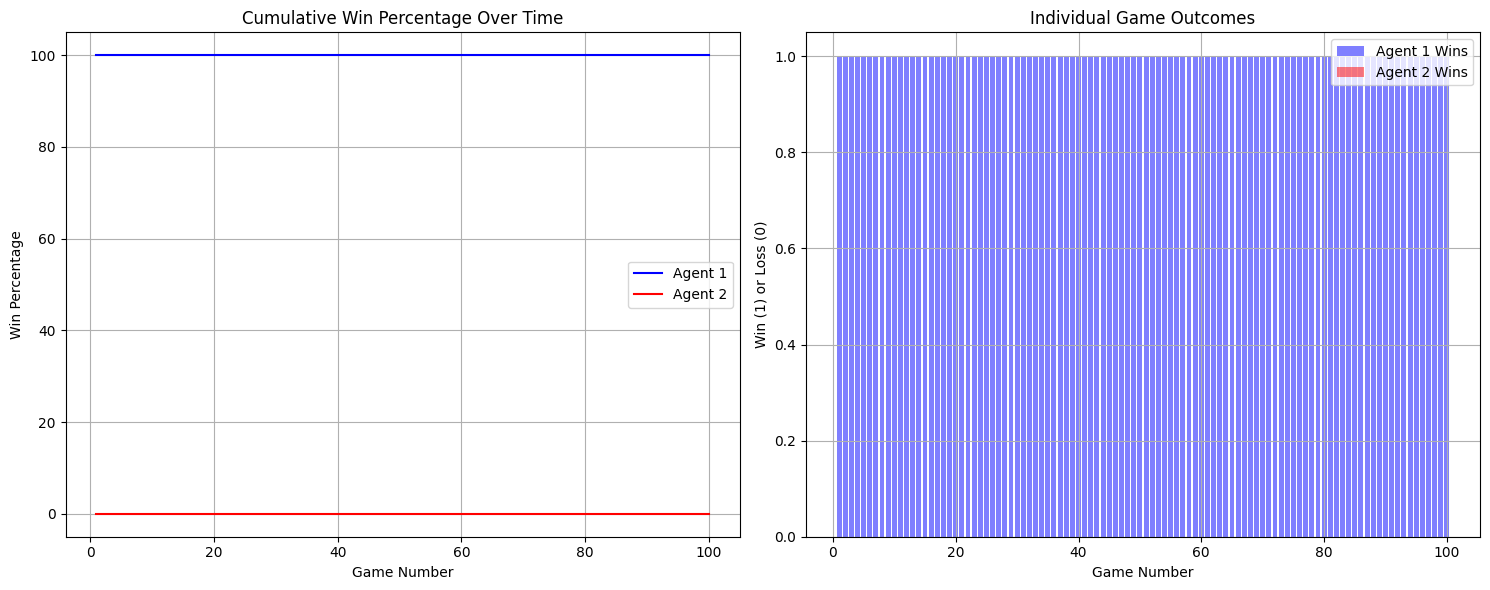

([[1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],
  [1, -1],

In [12]:
get_win_percentages(agent1=nega_max_agent, agent2="random")

  0%|          | 0/1 [00:00<?, ?it/s]

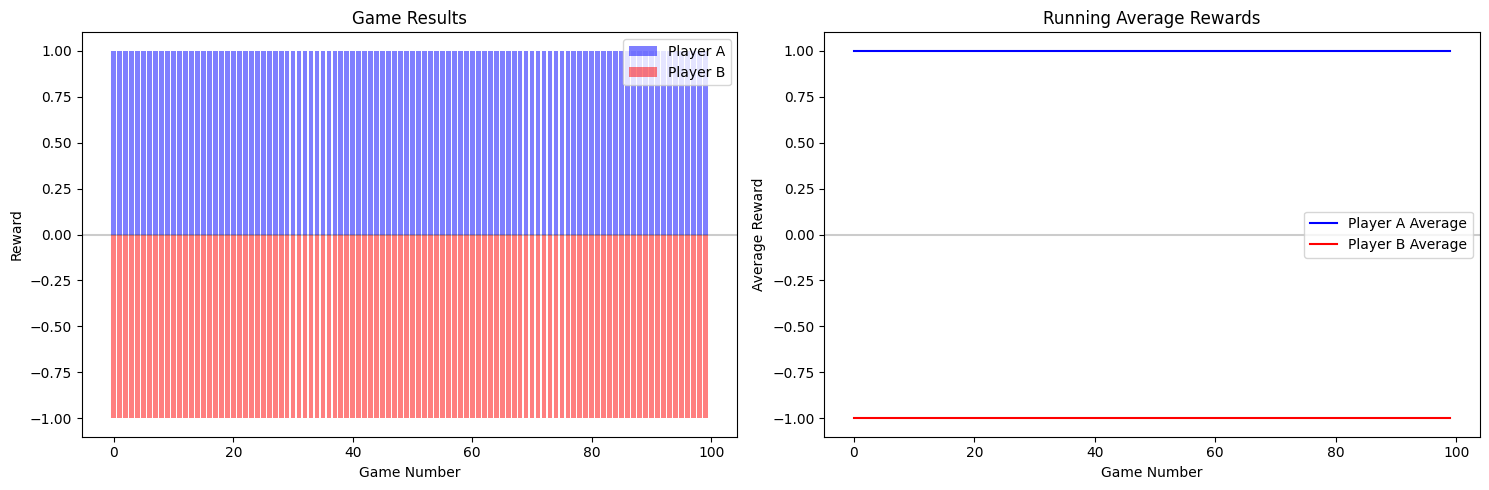

NegaMax vs random:
Player A Total: 100.00, Avg: 1.00, Errors: 0
Player B Total: -100.00, Avg: -1.00, Errors: 0



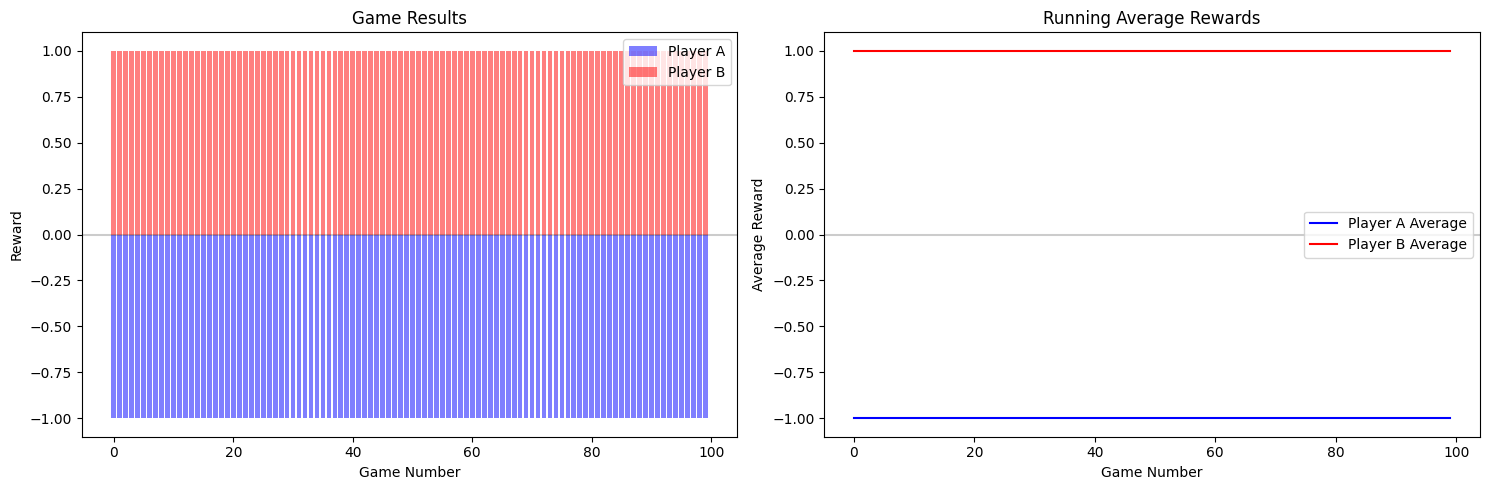

random vs NegaMax:
Player A Total: -100.00, Avg: -1.00, Errors: 0
Player B Total: 100.00, Avg: 1.00, Errors: 0



In [9]:
def mean_reward(rewards):
    """Enhanced version of original mean_reward function with visualization"""
    # Original functionality
    sum_A = 0
    nan_A = 0
    sum_B = 0
    nan_B = 0    
    
    # New tracking lists for visualization
    rewards_A = []
    rewards_B = []
    running_avg_A = []
    running_avg_B = []
    
    # Process rewards
    for n, r in enumerate(rewards):
        # Player A processing
        if r[0] is None:
            nan_A += 1
            rewards_A.append(0)  # Store 0 for visualization
        else:
            sum_A += r[0]
            rewards_A.append(r[0])
            
        # Player B processing    
        if r[1] is None:
            nan_B += 1
            rewards_B.append(0)  # Store 0 for visualization
        else:
            sum_B += r[1]
            rewards_B.append(r[1])
        
        # Calculate running averages
        running_avg_A.append(sum_A / (n + 1))
        running_avg_B.append(sum_B / (n + 1))
            
    # Calculate final averages
    avg_A = sum_A/float(len(rewards))
    avg_B = sum_B/float(len(rewards))
    
    # Original output string
    outp = "Player A Total: {:.2f}, Avg: {:.2f}, Errors: {}\n".format(sum_A, avg_A, nan_A)
    outp += "Player B Total: {:.2f}, Avg: {:.2f}, Errors: {}\n".format(sum_B, avg_B, nan_B)
    
    
    plt.figure(figsize=(15, 5))
    
    # Individual game results
    plt.subplot(1, 2, 1)
    games = range(len(rewards))
    plt.bar(games, rewards_A, alpha=0.5, label='Player A', color='blue')
    plt.bar(games, rewards_B, alpha=0.5, label='Player B', color='red')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    plt.title('Game Results')
    plt.xlabel('Game Number')
    plt.ylabel('Reward')
    plt.legend()
    
    # Running averages
    plt.subplot(1, 2, 2)
    plt.plot(games, running_avg_A, label='Player A Average', color='blue')
    plt.plot(games, running_avg_B, label='Player B Average', color='red')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    plt.title('Running Average Rewards')
    plt.xlabel('Game Number')
    plt.ylabel('Average Reward')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return outp

def print_mean_rewards(agent, against, num_episodes=100):
    """Original print_mean_rewards function using enhanced mean_reward"""
    for name, opponent in tqdm.notebook.tqdm(against):
        print(
            "{} vs {}:\n{}".format(
                agent[0],
                name,
                mean_reward(
                    evaluate("connectx", [agent[1], opponent], num_episodes=num_episodes)
                ),
            )
        )
        print(
            "{} vs {}:\n{}".format(
                name,
                agent[0],
                mean_reward(
                    evaluate("connectx", [opponent, agent[1]], num_episodes=num_episodes)
                ),
            )
        )    

# Example usage:
print_mean_rewards(("NegaMax", nega_max_agent), [("random", "random")], num_episodes=100)

Analyzing games between NegaMax and Random agents...
Running games with Agent 1 first...
Running games with Agent 2 first...


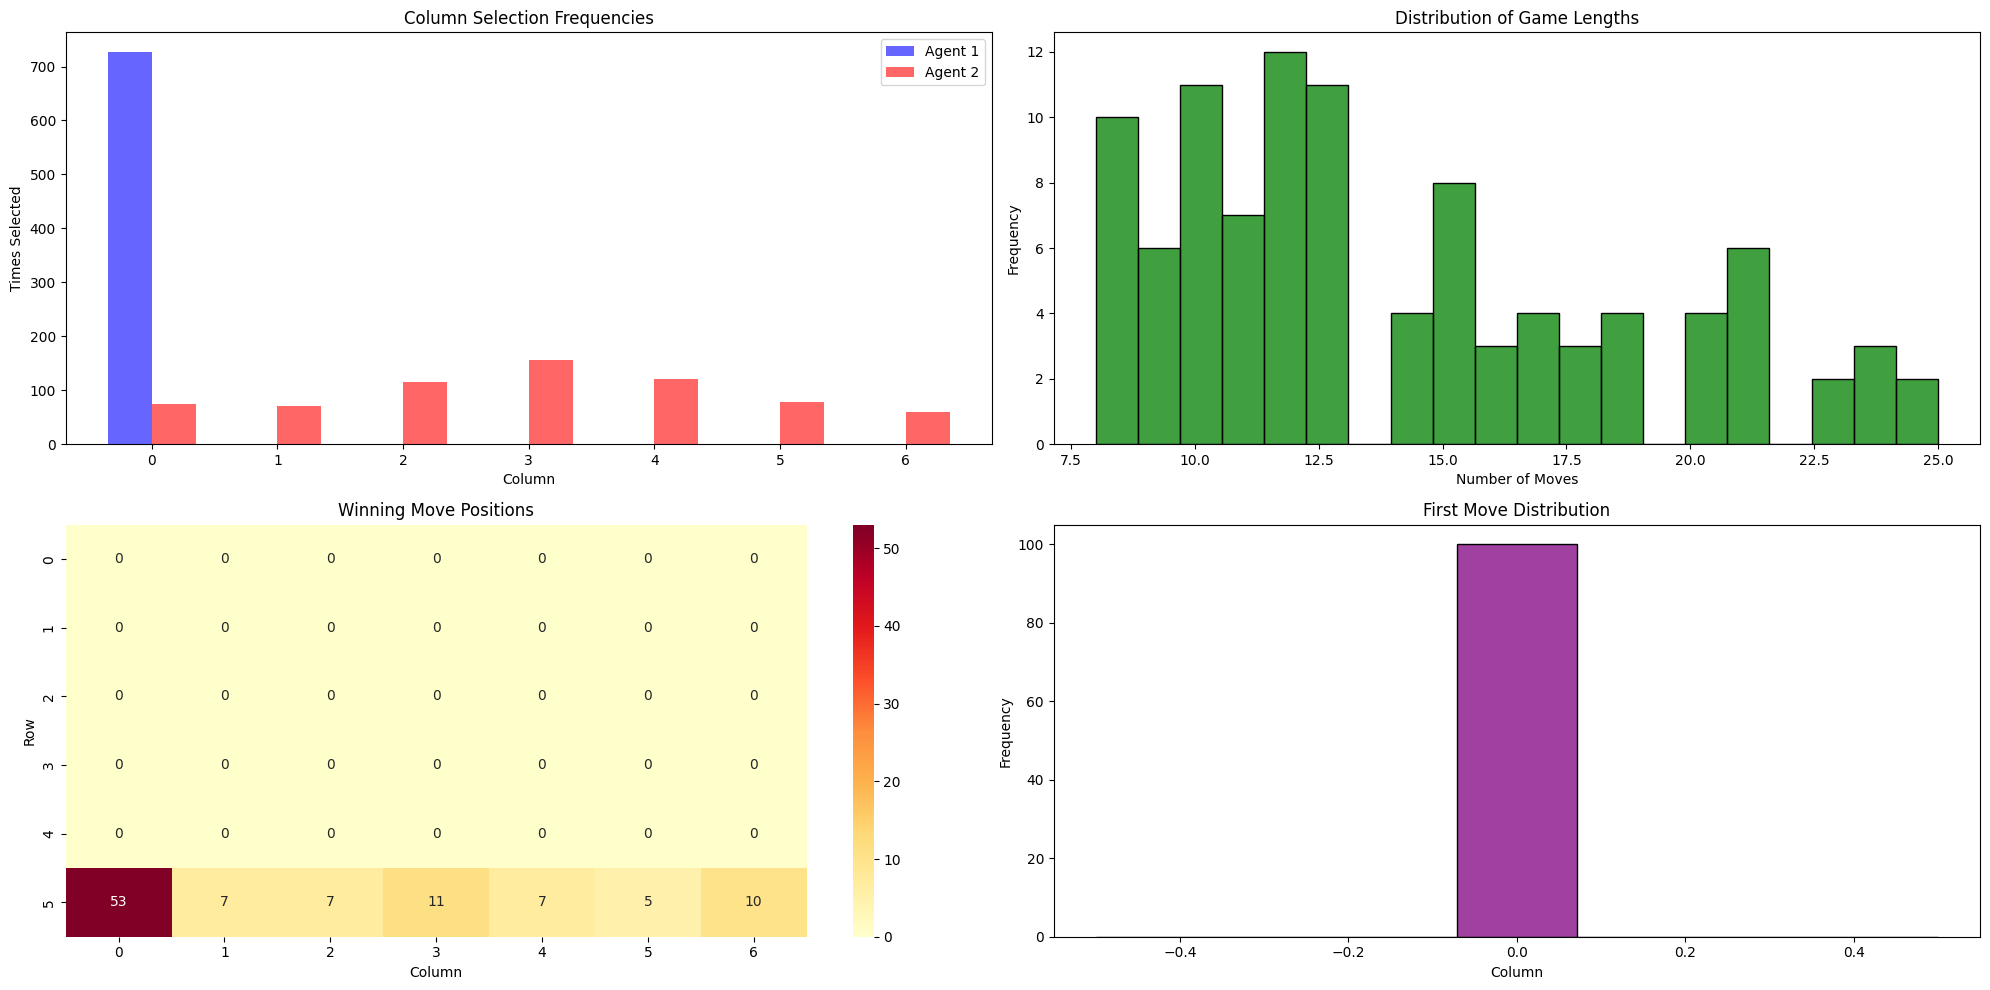


Summary Statistics:
Average game length: 14.04 moves
Most common first move: Column 0
Most frequently played column: Column 0
Most successful winning column: Column 0


In [8]:
def analyze_games(agent1, agent2, n_rounds=100):
    """
    Comprehensive analysis of Connect 4 games between two agents.
    """
    
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    
    # Storage for analysis
    column_choices = defaultdict(lambda: [0] * 7)  # Store column selection frequencies
    move_sequences = []  # Store game move sequences
    game_lengths = []    # Store number of moves per game
    wins_by_position = defaultdict(int)  # Track wins by last move position
    
    def record_game(steps, winner):
        """Record detailed game information"""
        moves = []
        for step in steps:
            if step[0]['action'] is not None:  # Valid move
                moves.append(step[0]['action'])
        
        game_lengths.append(len(moves))
        move_sequences.append(moves)
        
        # Record column choices for each agent
        for i, move in enumerate(moves):
            if i % 2 == 0:  # Agent 1's moves
                column_choices['agent1'][move] += 1
            else:  # Agent 2's moves
                column_choices['agent2'][move] += 1
                
        # Record winning position if game was won
        if winner is not None and moves:
            wins_by_position[moves[-1]] += 1
    
    # Run games - Agent 1 first
    print("Running games with Agent 1 first...")
    first_half = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    env = make("connectx", debug=True)
    
    for _ in range(n_rounds//2):
        env.reset()
        steps = env.run([agent1, agent2])
        winner = None
        if steps[-1][0]['reward'] == 1:
            winner = 'agent1'
        elif steps[-1][1]['reward'] == 1:
            winner = 'agent2'
        record_game(steps, winner)
    
    # Run games - Agent 2 first
    print("Running games with Agent 2 first...")
    for _ in range(n_rounds - n_rounds//2):
        env.reset()
        steps = env.run([agent2, agent1])
        winner = None
        if steps[-1][0]['reward'] == 1:
            winner = 'agent2'
        elif steps[-1][1]['reward'] == 1:
            winner = 'agent1'
        record_game(steps, winner)
    
    # Create visualizations
    plt.figure(figsize=(20, 10))
    
    # 1. Column Selection Frequencies
    plt.subplot(2, 2, 1)
    x = np.arange(7)
    width = 0.35
    plt.bar(x - width/2, column_choices['agent1'], width, label='Agent 1', color='blue', alpha=0.6)
    plt.bar(x + width/2, column_choices['agent2'], width, label='Agent 2', color='red', alpha=0.6)
    plt.title('Column Selection Frequencies')
    plt.xlabel('Column')
    plt.ylabel('Times Selected')
    plt.legend()
    
    # 2. Game Length Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(game_lengths, bins=20, color='green')
    plt.title('Distribution of Game Lengths')
    plt.xlabel('Number of Moves')
    plt.ylabel('Frequency')
    
    # 3. Winning Positions Heatmap
    plt.subplot(2, 2, 3)
    win_data = np.zeros((6, 7))
    for col, count in wins_by_position.items():
        row = 5
        while row >= 0 and win_data[row][col] != 0:
            row -= 1
        if row >= 0:
            win_data[row][col] = count
    
    sns.heatmap(win_data, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.title('Winning Move Positions')
    plt.xlabel('Column')
    plt.ylabel('Row')
    
    # 4. First Move Analysis
    plt.subplot(2, 2, 4)
    first_moves = [seq[0] for seq in move_sequences if seq]
    sns.histplot(first_moves, bins=7, color='purple')
    plt.title('First Move Distribution')
    plt.xlabel('Column')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Average game length: {np.mean(game_lengths):.2f} moves")
    print(f"Most common first move: Column {max(set(first_moves), key=first_moves.count)}")
    print(f"Most frequently played column: Column {max(range(7), key=lambda x: column_choices['agent1'][x] + column_choices['agent2'][x])}")
    
    most_winning_col = max(wins_by_position.items(), key=lambda x: x[1])[0]
    print(f"Most successful winning column: Column {most_winning_col}")
    
    return {
        'column_choices': column_choices,
        'game_lengths': game_lengths,
        'move_sequences': move_sequences,
        'wins_by_position': wins_by_position
    }

# Run the analysis
print("Analyzing games between NegaMax and Random agents...")
results = analyze_games(nega_max_agent, "random", n_rounds=100)

In [20]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import gym
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym(gym.Env):
    def __init__(self, agent2=nega_max_agent):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(1,self.rows,self.columns), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, done, _

In [21]:
# Create ConnectFour environment 
env = ConnectFourGym(agent2=nega_max_agent)
print(env)

<ConnectFourGym instance>


In [22]:
import torch as th
import torch.nn as nn
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import BaseCallback  # Added this import
from tqdm.auto import tqdm
import numpy as np

class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

class ProgressBarCallback(BaseCallback):
    def __init__(self, total_timesteps):
        super().__init__()
        self.total_timesteps = int(total_timesteps)
        
    def _on_training_start(self):
        self.current_count = 0
        self.pbar = tqdm(
            total=self.total_timesteps,
            desc='Training',
            leave=True
        )

    def _on_step(self) -> bool:
        """Update the progress bar and print episode stats"""
        self.current_count += 1
        self.pbar.update(1)
        
        # Always print every 1000 steps
        if self.current_count % 1000 == 0:
            print(f"\nStep {self.current_count}/{self.total_timesteps}")
            
            # Get the most recent rewards from the model
            if hasattr(self.model, 'ep_info_buffer') and len(self.model.ep_info_buffer) > 0:
                latest_reward = self.model.ep_info_buffer[-1]['r']
                latest_length = self.model.ep_info_buffer[-1]['l']
                print(f"  Latest Episode Reward: {latest_reward:.2f}")
                print(f"  Latest Episode Length: {latest_length}")
                
                # Update progress bar
                self.pbar.set_postfix(
                    reward=f"{latest_reward:.2f}",
                    length=str(latest_length),
                    refresh=True
                )
            else:
                print("  No episode completed yet")
            
            # Print current policy stats
            if hasattr(self.model, 'logger') and hasattr(self.model.logger, 'name_to_value'):
                for key, value in self.model.logger.name_to_value.items():
                    print(f"  {key}: {value}")
        
        return True

    def _on_training_end(self):
        """Clean up progress bar resources"""
        self.pbar.close()

# Setup and training with larger timesteps
TOTAL_TIMESTEPS = 60_000  # 60,000 timesteps

policy_kwargs = dict(features_extractor_class=CustomCNN)
model = PPO("CnnPolicy", 
           env, 
           policy_kwargs=policy_kwargs, 
           verbose=0,
           n_steps=2048)  # Increased n_steps for better training

# Create callback with larger timestep limit
progress_callback = ProgressBarCallback(TOTAL_TIMESTEPS)

# Train agent
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=progress_callback)

2024-11-08 13:36:09.003483: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 13:36:09.219368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 13:36:09.297984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 13:36:09.320865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 13:36:09.474834: I tensorflow/core/platform/cpu_feature_guar

Training:   0%|          | 0/60000 [00:00<?, ?it/s]


Step 1000/60000
  Latest Episode Reward: -0.81
  Latest Episode Length: 9

Step 2000/60000
  Latest Episode Reward: -0.88
  Latest Episode Length: 6

Step 3000/60000
  Latest Episode Reward: -0.83
  Latest Episode Length: 8
  train/learning_rate: 0.0003
  train/entropy_loss: -1.937627386674285
  train/policy_gradient_loss: -0.016700713979662395
  train/value_loss: 1.7747929284814745
  train/approx_kl: 0.009270480833947659
  train/clip_fraction: 0.093408203125
  train/loss: 0.08659873902797699
  train/explained_variance: -0.022055387496948242
  train/n_updates: 10
  train/clip_range: 0.2

Step 4000/60000
  Latest Episode Reward: -0.88
  Latest Episode Length: 6
  train/learning_rate: 0.0003
  train/entropy_loss: -1.937627386674285
  train/policy_gradient_loss: -0.016700713979662395
  train/value_loss: 1.7747929284814745
  train/approx_kl: 0.009270480833947659
  train/clip_fraction: 0.093408203125
  train/loss: 0.08659873902797699
  train/explained_variance: -0.022055387496948242
  trai

In [44]:
def agent1(obs, config): #Name of agent TBD 'agent1'
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(1, 6,7))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [28]:
# Create the game environment
env = make("connectx")

# Two random agents play one game round
env.run([agent1, nega_max_agent])

# Show the game
env.render(mode="ipython")

In [40]:
get_win_percentages(agent1=agent1, agent2=nega_max_agent)

NameError: name 'get_win_percentages' is not defined